In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Image: /home/nan/sneaker_ai/screened_data/air_jordan_13/air_jordan_13_227.jpg
Label: AJ +  13
(639, 958, 3)


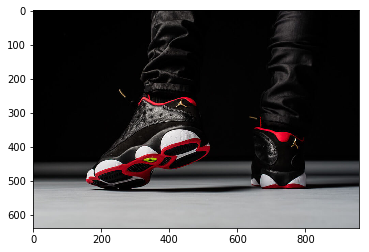

In [2]:
import random

all_df = pd.read_csv('dataset_df.csv')
n = random.randint(0, len(all_df)-1)
image_file = all_df.iloc[n,1]
label = all_df.iloc[n,2]
print("Image:", image_file)
print("Label: AJ + ", str(label+1))
print(io.imread(image_file).shape)
plt.imshow(io.imread(image_file))

In [3]:
class AJDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, n):
        img_name = self.df.iloc[n,1]
        image = io.imread(img_name)
        label = self.df.iloc[n,2]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [4]:
n_classes = 23
classes = ["AJ "+ str(i) for i in range(1,n_classes+1)]
batch_size = 16

## add random transforms for data augmentation
transform = transforms.Compose(
                    [transforms.ToPILImage(),
                     transforms.Lambda(lambda image: image.convert('RGB')),
                     transforms.ColorJitter(brightness=0.2, contrast=0.2),
                     transforms.Resize(size=256),
                     transforms.RandomCrop(224),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor(),
                     ])

train_dataset = AJDataset('train_df.csv', transform = 
transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,shuffle = True)

test_dataset = AJDataset('test_df.csv', transform = 
transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                batch_size=batch_size,shuffle = True)


tensor(0.)
tensor(1.)
AJ 1
torch.Size([3, 224, 224])
<class 'numpy.ndarray'>


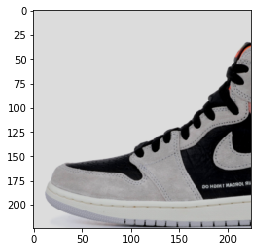

In [5]:
imgs, lbls = next(iter(train_loader))
imgs[0].data.shape
print(imgs.data.min())
print(imgs.data.max())
print(classes[lbls[0]])
print(imgs[0].shape)
print(type(imgs[0].numpy()))
plt.imshow(imgs[0].numpy().transpose((1,2,0)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)

In [7]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-6)

Epoch: 50/50..  Training Loss: 0.141..  Training Accuracy: 0.979..  Test Loss: 0.376..  Test Accuracy: 0.911
Epoch 50 / 50 took 230.76 seconds
Total training time till this epoch was 11644.39 seconds


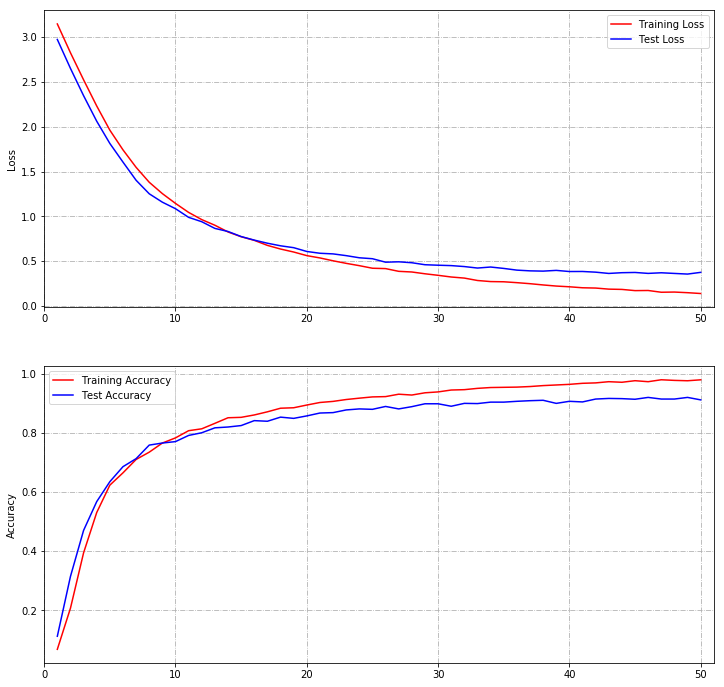

In [8]:
import time
from IPython.display import clear_output

epochs = 50
train_losses, test_losses = [], []
train_accu, test_accu = [], []
start_time = time.time()
for e in range(epochs):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        
        ps = torch.exp(log_ps)                
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        train_losses.append(running_loss/len(train_loader))
        train_accu.append(accuracy/len(train_loader))
        
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        test_losses.append(test_loss/len(test_loader))
        test_accu.append(accuracy/len(test_loader))

        clear_output(wait=True)
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Training Accuracy: {:.3f}.. ".format(train_accu[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(test_accu[-1]))
    
        print('Epoch %d / %d took %6.2f seconds' % (e+1, epochs, time.time()-epoch_start_time))
        print('Total training time till this epoch was %8.2f seconds' % (time.time()-start_time))

        plt.figure(figsize=(12,12))
        plt.subplot(2,1,1)
        ax = plt.gca()
        ax.set_xlim([0, epochs + 1])
        plt.ylabel('Loss')
        plt.plot(range(1, e + 2), train_losses[:e+1], 'r', label='Training Loss')
        plt.plot(range(1, e + 2), test_losses[:e+1], 'b', label='Test Loss')
        ax.grid(linestyle='-.')
        plt.legend()
        plt.subplot(2,1,2)
        ax = plt.gca()
        ax.set_xlim([0, epochs + 1])
        plt.ylabel('Accuracy')
        plt.plot(range(1, e + 2), train_accu[:e+1], 'r', label='Training Accuracy')
        plt.plot(range(1, e + 2), test_accu[:e+1], 'b', label='Test Accuracy')
        ax.grid(linestyle='-.')
        plt.legend()
        plt.show()
        if (e+1) % 10 == 0:
            torch.save(model.state_dict(), 'model_resnet18--{}.ckpt'.format(e+1))
torch.save(model.state_dict(), 'model_resnet18--{}.ckpt'.format(e+1))


In [9]:
train_loss = 0
accuracy = 0
with torch.no_grad():
    images,labels = next(iter(train_loader))
    images = images.to(device)
    labels = labels.to(device)
    log_ps = model(images)
    train_loss += criterion(log_ps, labels)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))

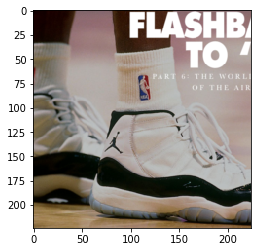

In [10]:
plt.imshow(images[3].cpu().numpy().reshape((3,224,224)).transpose(1,2,0))

In [11]:
labels

tensor([13, 12, 19, 10,  7, 11, 11,  3,  0,  8, 20, 21,  3, 11,  0, 11],
       device='cuda:0')

In [12]:
top_class.view((1, -1))

tensor([[13, 12, 19, 10,  7, 11, 11,  3,  0,  8, 20, 21,  3, 11,  0, 11]],
       device='cuda:0')

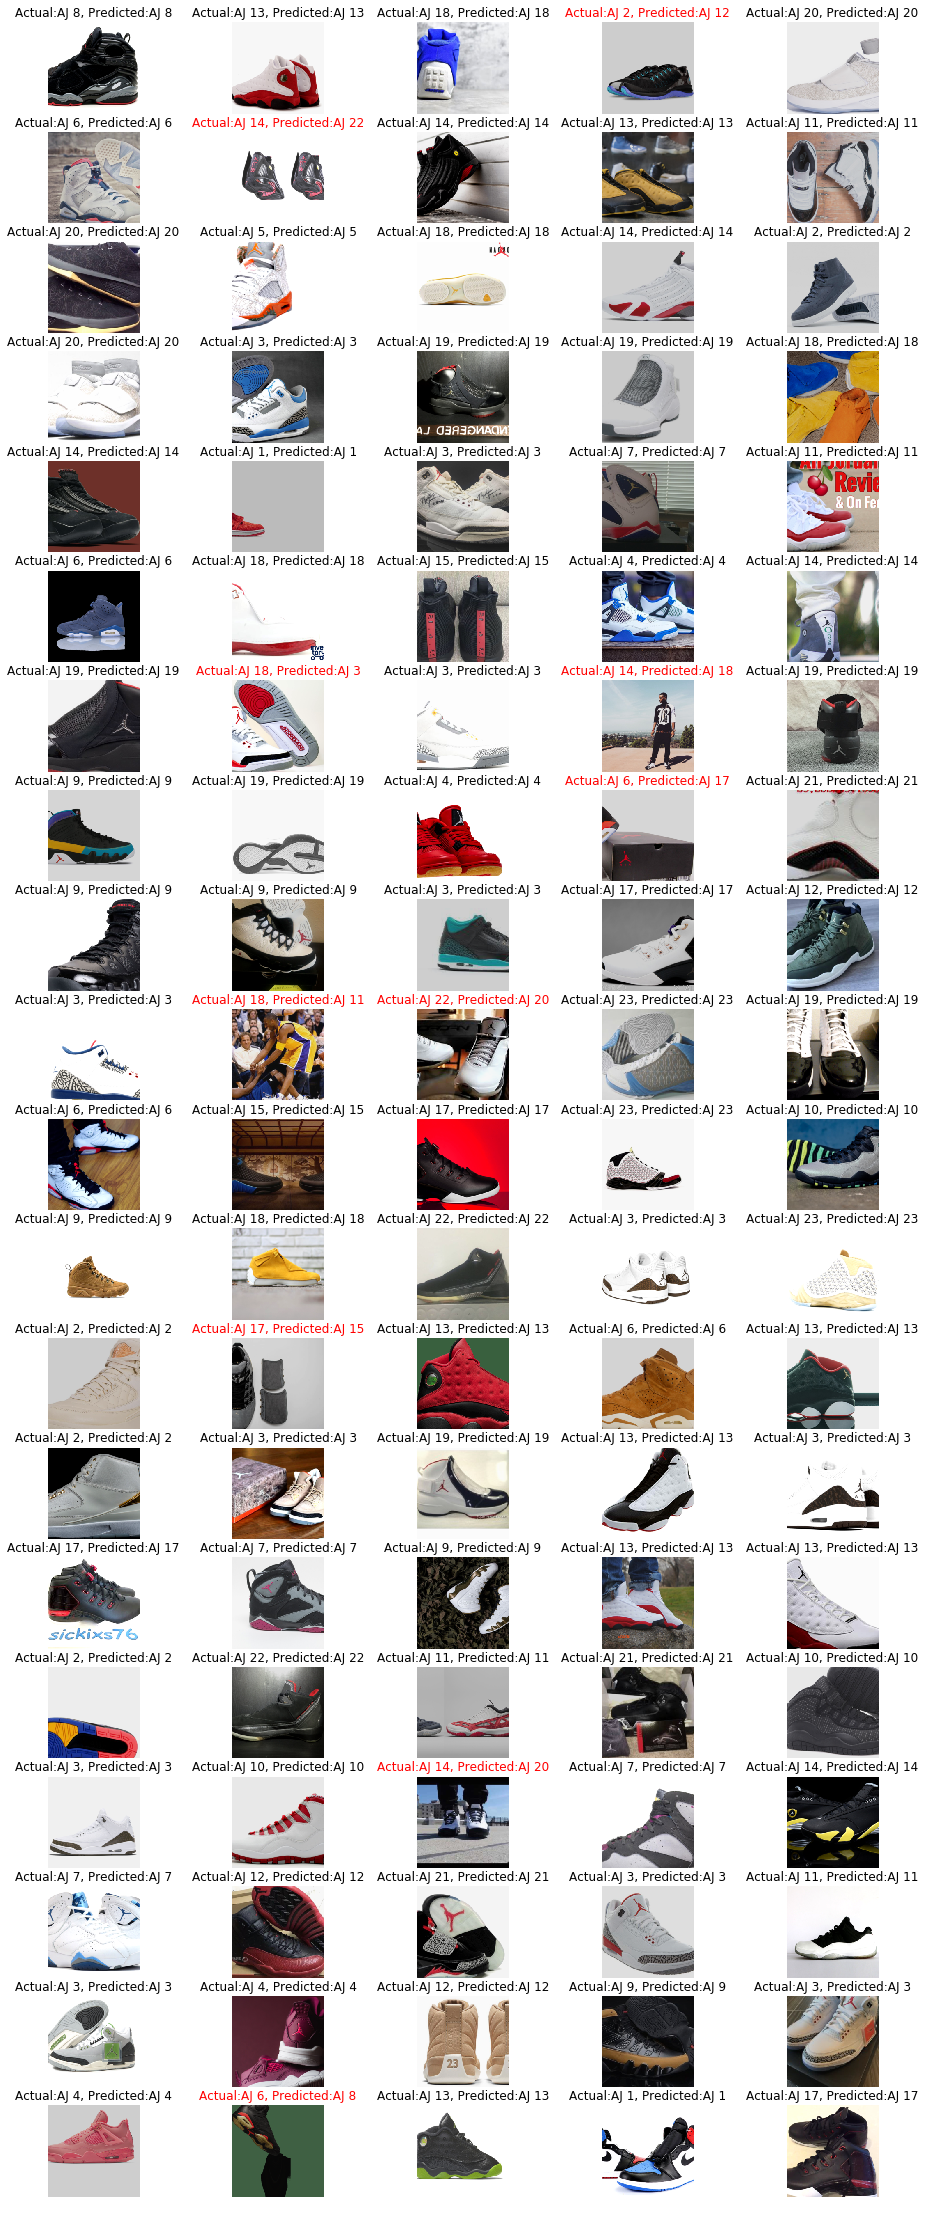

In [13]:
def visualize_model(model, num_images=100):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(16,40))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//5, 5, images_so_far)
                ax.axis('off')
                ax.set_title('Actual:{}, Predicted:{}'.format(classes[labels[j]], classes[preds[j]]),
                            color = 'k' if labels[j]==preds[j] else 'r' )
#                 print(inputs.cpu().data[j].shape)
                plt.imshow(inputs.cpu().data[j].numpy().transpose(1,2,0))

                if images_so_far == num_images:
                    model.train()
                    return
        model.train()

visualize_model(model)
plt.savefig('test_result_resnet18.jpg')
# plt.show()


[[45  0  0  1  0  0  0  0  0  0  1  0  1  0  0  1  0  0  0  0  0  0  0]
 [ 1 38  0  0  0  0  0  0  1  0  0  3  1  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 65  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  1 45  1  1  0  0  0  0  0  0  0  0  0  0  1  0  0  1  1  0  0]
 [ 0  0  0  1 27  2  0  0  0  0  2  0  0  0  0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  2  0  2  0  0  0  0  0]
 [ 0  0  0  0  1  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 28  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 46  0  1  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  1  0  0 44  1  0  0  0  0  0  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  1  2  1 52  0  0  0  0  0  0  3  0  1  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  0  1 63  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0 43  0  1  0  0  0  1  0

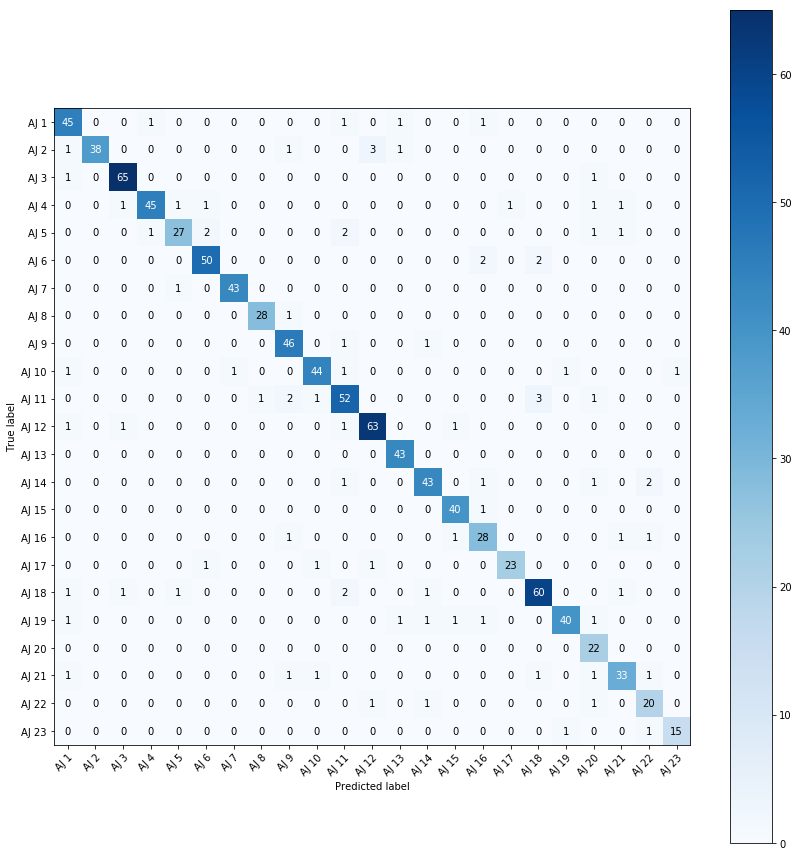

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, classes, num_images=1000, normalize=False):
    model.eval()
    images_so_far = 0
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                y_true.append(labels[j].cpu().numpy())
                y_pred.append(preds[j].cpu().numpy())
                images_so_far += 1
                if images_so_far == num_images:
#                     print(y_true, y_pred)
                    cm = confusion_matrix(y_true, y_pred)
                    print(cm)
                    fig, ax = plt.subplots(figsize=(12,12))
                    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
                    ax.figure.colorbar(im, ax=ax)
                    ax.set(xticks=np.arange(cm.shape[1]),
                           yticks=np.arange(cm.shape[0]),
                           # ... and label them with the respective list entries
                           xticklabels=classes, yticklabels=classes,
                           ylabel='True label',
                           xlabel='Predicted label')
                    # Rotate the tick labels and set their alignment.
                    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                             rotation_mode="anchor")
                    # Loop over data dimensions and create text annotations.
                    fmt = '.2f' if normalize else 'd'
                    thresh = cm.max() / 2.
                    for i in range(cm.shape[0]):
                        for j in range(cm.shape[1]):
                            ax.text(j, i, format(cm[i, j], fmt),
                                    ha="center", va="center",
                                    color="white" if cm[i, j] > thresh else "black")
                    fig.tight_layout()
                    model.train()
                    return
        model.train()

plot_confusion_matrix(model, classes, num_images=1000)
plt.savefig('tl_resnet18_confusion_matrix.jpg')